# 丢弃法

- 比权重衰退效果更好
- 实际上也是一个正则，只在对权重产生影响，只在训练时使用。预测是不需要正则
<img src="./pic/丢弃法.PNG" width=300 height=300>

## 动机

- 一个好的模型需要对输入数据的干扰，鲁棒
    - 不管加入多少噪音，还是能看清图片
    - 使用有噪音的数据等价于Tikhonov正则
    - 丢弃法：（不在输入加噪音）在层之间加入噪音
    
## 无偏差的加入噪音
- 虽然加入了噪音，但不要改变期望E
- p是丢弃当前数据的概率
- 在概率为p时，x<sup>'</sup><sub>i</sub> = 0；在其他概率，增大x<sub>i</sub>
<img src="./pic/无偏差的加入噪音.PNG" width=300 height=300>

    
## 使用丢弃法

<img src="./pic/使用丢弃法.PNG" width=300 height=300>

## 推理中的丢弃法
<img src="./pic/推理中的丢弃法.PNG" width=300 height=300>


## 总结
- 丢弃法将一些输出项随机置0来控制模型复杂度
- 常作用在多层感知机的隐藏层输出上
- 丢弃概率是控制模型复杂度的超参数（p = 0.1，0.5，0.9）

# 2. Dropout 代码（从零开始实现）
- 实现 dropout_layer 函数， 该函数以dropout的概率丢弃张量输入X中的元素

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    # 大于dropout的元素返回1，小于dropout的元素返回0
    mask = (torch.rand(X.shape) > dropout).float()    
    return mask * X / (1.0 - dropout)

# rand是产生0~1之间的均匀分布；randn是产生均值为0，方差为1的高斯分布


In [6]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  0.,  0., 10., 12.,  0.],
        [16., 18.,  0.,  0., 24.,  0.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [18]:
# 小于dropout的返回0，大于dropout的增大元素值
origin = torch.rand(X.shape)
mask = (origin > 0.5).float()
origin, mask, X, mask * X / (1.0 - 0.5)

(tensor([[0.1702, 0.1714, 0.1463, 0.7415, 0.3723, 0.2201, 0.3559, 0.6994],
         [0.0392, 0.4702, 0.2885, 0.5866, 0.9734, 0.5818, 0.4621, 0.7467]]),
 tensor([[0., 0., 0., 1., 0., 0., 0., 1.],
         [0., 0., 0., 1., 1., 1., 0., 1.]]),
 tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11., 12., 13., 14., 15.]]),
 tensor([[ 0.,  0.,  0.,  6.,  0.,  0.,  0., 14.],
         [ 0.,  0.,  0., 22., 24., 26.,  0., 30.]]))

## 定义模型
- 定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元

In [20]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

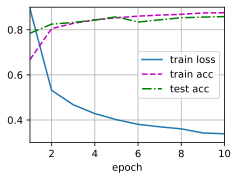

In [21]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 3. 简洁实现

In [22]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

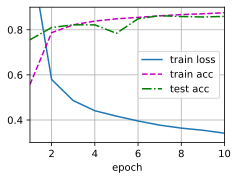

In [23]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)